Demonstration of slow-varying reactivation profile due to randomly drifting excitabilities.

# Params

In [1]:
%matplotlib inline
from copy import deepcopy as copy
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter1d as smooth
import sys

from aux import r_tile, c_tile, Generic
from disp import set_font_size, set_color, fast_fig
from ntwk import BinarySTDPNtwk

cc = np.concatenate


# PARAMS
N_SEED = 20

## DYNAMICS/ADAPTATION
N_MAX = 150
THT_S = 1
T_THT = 6
A_THT = 1.5

## STRUCTURE
N = 1000
M = 200
Q = .1
W_MIN = THT_S/50 + .0001
W_MAX = THT_S/4 + .0001

## DRIVE
N_T = 1000
ITVL_REAC = 25  # TIME BTWN REACTIVATION EVENTS
T_REAC = np.arange(ITVL_REAC, N_T, ITVL_REAC)
I_STD_0 = .2  # BASELINE NOISE
I_STD_1 = .85  # REACTIVATION NOISE

TAU_I_SLOW = 100
I_MEAN_SLOW = 0
I_STD_SLOW = 0.1 * np.arange(0, 6, dtype=float)  # LOOP OVER BASELINE INPUT (~EXCITABILITY) STD

# ANALYSIS
PRFL_CTR = [0, 1, 2, 10, 11, 12, -3, -2, -1]  # which events to measure reactivation profiles for
T_PRFL = 4  # how many timesteps post reactivation stim to count spks

# Simulation

In [2]:
rslt_xpl = []
r_v_dt_fulls = []
r_v_dt_enss = []

for i_std_slow in I_STD_SLOW:
    print('\nI_STD = {}'.format(i_std_slow))
    
    r_v_dt_full_tmp = []
    r_v_dt_ens_tmp = []
    
    for seed in np.arange(N_SEED):
        sys.stdout.write('.')
        np.random.seed(seed)

        # set up weights
        cxn = np.random.rand(N, N) < Q
        w_0 = np.zeros((N, N))
        w_0[cxn] = W_MIN

        # set up strongly connected ensemble
        ens_mask = np.zeros(N, dtype=bool)
        ens_mask[:M] = True
        ens_cxn = cxn & np.outer(ens_mask, ens_mask)
        w_0[ens_cxn] = W_MAX

        # set up inputs
        i_ext = I_STD_0 * np.random.randn(N_T, N)
        
        i_reac = I_STD_1 * np.random.randn(N)
        i_ext[T_REAC, :] = i_reac

        i_slow = smooth(np.random.randn(N_T, N), TAU_I_SLOW, axis=0)
        i_slow *= (i_std_slow / i_slow.std(axis=0))
        i_slow += I_MEAN_SLOW

        # add in slow-varying baseline inputs
        i_ext += i_slow

        # build ntwk and run smln
        ntwk = BinarySTDPNtwk(
            cxn=cxn,
            w_0=w_0,
            tht_s=THT_S,
            t_tht=T_THT,
            a_tht=A_THT,
            n_max=N_MAX,
            t_stdp=np.arange(-10, 10),
            d_w_s=np.zeros(20),
            w_min=W_MIN,
            w_max=W_MAX)

        rslt = ntwk.run(i_ext=i_ext, change_w=None)
            
        # analysis
        prfls = []
        orders = []

        for ctr in PRFL_CTR:
            # calc cell participations during reactivation
            prfl = rslt.spks[T_REAC[ctr]+1:T_REAC[ctr]+T_PRFL+1, :].sum(0)
            prfls.append(prfl)

            # sort cells by participation
            order = prfl.argsort()[::-1]
            prfl_sorted = prfl[order]

            # randomly permute sorted idxs of cells that had same num spikes during reactivation
            # (to avoid sorting algorithm artifacts when multiple cells have same participation)
            for n_spks in range(prfl_sorted.max() + 1):
                tmp = order[prfl_sorted == n_spks].copy()
                np.random.shuffle(tmp)
                order[prfl_sorted == n_spks] = tmp

            orders.append(order)

        # full participation profile covariance across reactivation events
        prfls_full = []
        for ctr in range(len(T_REAC)):
            prfl_full = rslt.spks[T_REAC[ctr]+1:T_REAC[ctr]+T_PRFL+1, :].sum(0)
            prfls_full.append(prfl_full)

        prfls_full = np.array(prfls_full)
        
        r_prfls_full = np.corrcoef(prfls_full)
        r_prfls_ens = np.corrcoef(prfls_full[:, :M])
        
        r_v_dt_full = np.array([np.diagonal(r_prfls_full, offset).mean() for offset in np.arange(len(T_REAC))])
        r_v_dt_ens = np.array([np.diagonal(r_prfls_ens, offset).mean() for offset in np.arange(len(T_REAC))])
        
        r_v_dt_full_tmp.append(r_v_dt_full)
        r_v_dt_ens_tmp.append(r_v_dt_ens)
        
        # save example result
        if seed == 0:
            rslt.prfls = prfls
            rslt.orders = orders
            rslt.prfls_full = prfls_full
            rslt.r_prfls_full = r_prfls_full
            rslt.r_prfls_ens = r_prfls_ens
            rslt.r_v_dt_full = r_v_dt_full
            rslt.r_v_dt_ens = r_v_dt_ens
            rslt_xpl.append(rslt)
            
    r_v_dt_fulls.append(np.mean(r_v_dt_full_tmp, 0))
    r_v_dt_enss.append(np.mean(r_v_dt_ens_tmp, 0))


I_STD = 0.0
....................
I_STD = 0.1
....................
I_STD = 0.2
....................
I_STD = 0.30000000000000004
....................
I_STD = 0.4
....................
I_STD = 0.5
....................

# Results

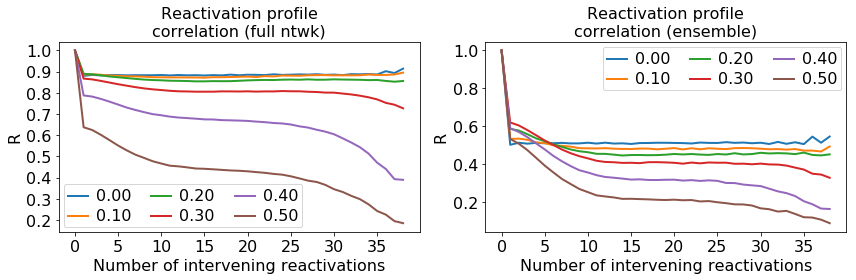

In [3]:
# plot reactivation profile correlation vs time diff btwn events
fig, axs = plt.subplots(1, 2, figsize=(12, 4), tight_layout=True)

for r_v_dt_full_mean, r_v_dt_ens_mean in zip(r_v_dt_fulls, r_v_dt_enss):
    axs[0].plot(np.arange(len(T_REAC)), r_v_dt_full_mean, lw=2)
    axs[0].set_title('Reactivation profile\ncorrelation (full ntwk)')

    axs[1].plot(np.arange(len(T_REAC)), r_v_dt_ens_mean, lw=2)
    axs[1].set_title('Reactivation profile\ncorrelation (ensemble)')

    for ax in axs:
        ax.set_xlabel('Number of intervening reactivations')
        ax.set_ylabel('R')
        ax.legend(['{0:.2f}'.format(i_std_slow) for i_std_slow in I_STD_SLOW], ncol=3)
        set_font_size(ax, 16)

# Example simulations

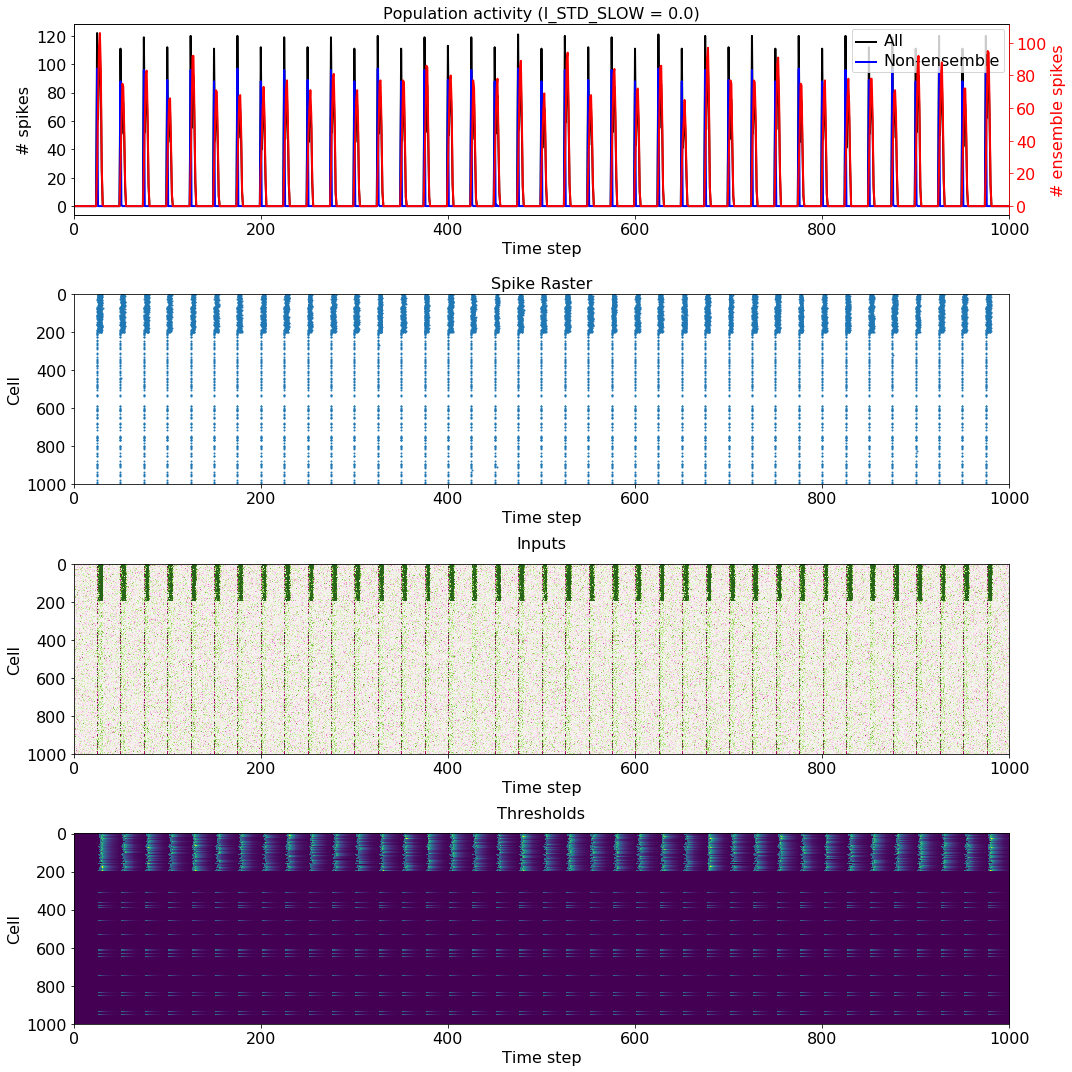

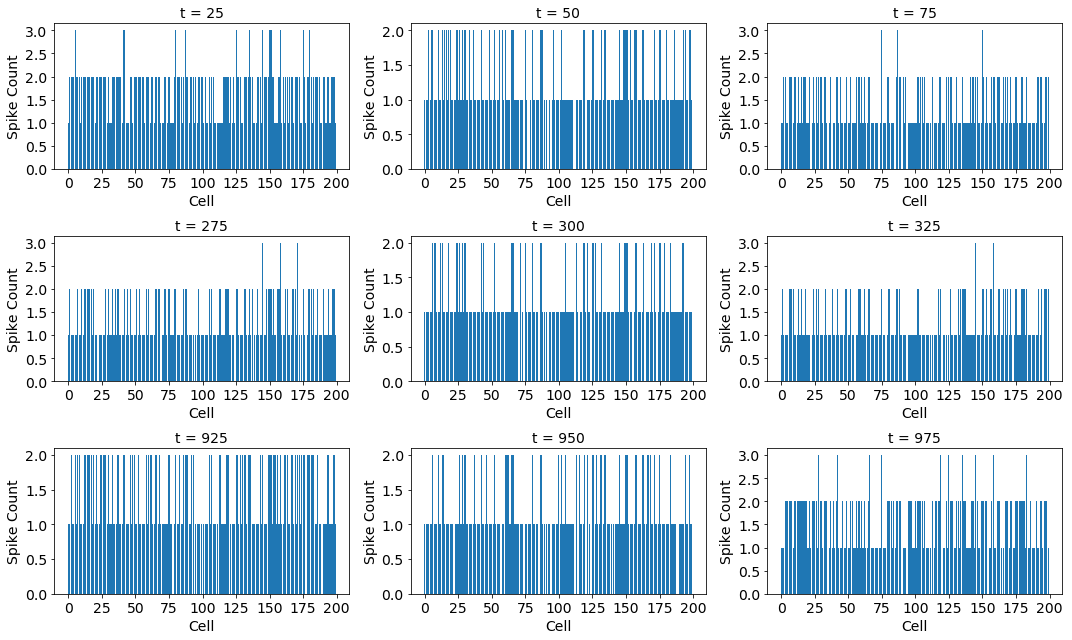

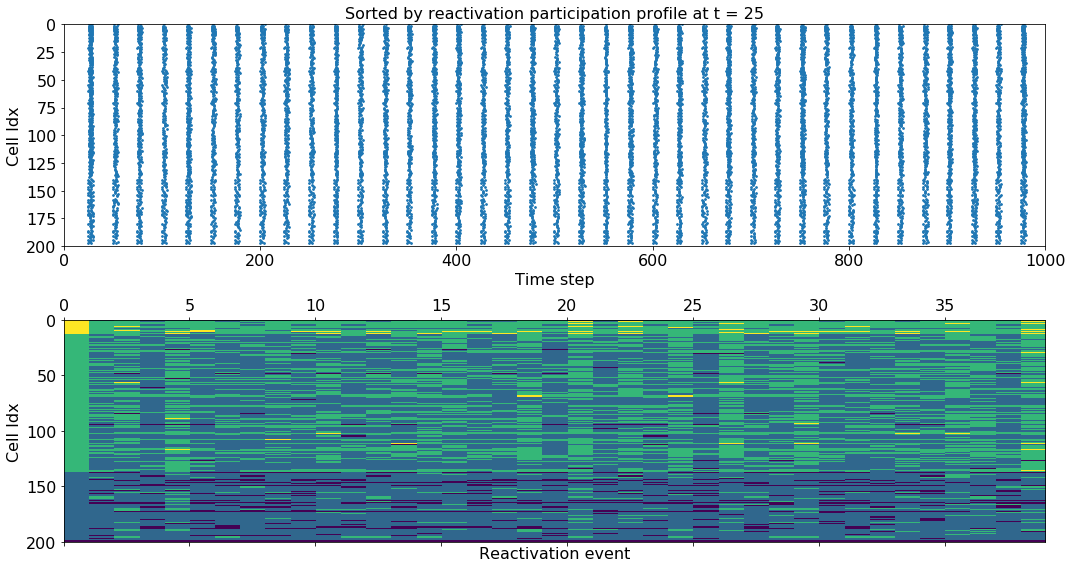

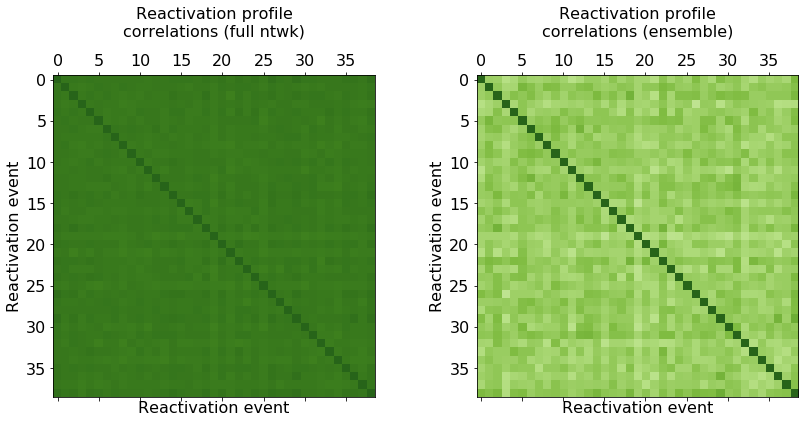

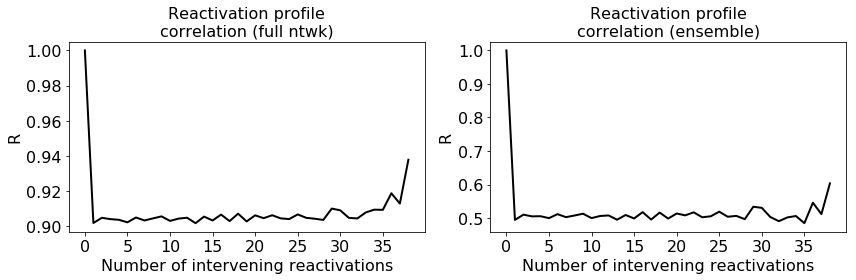

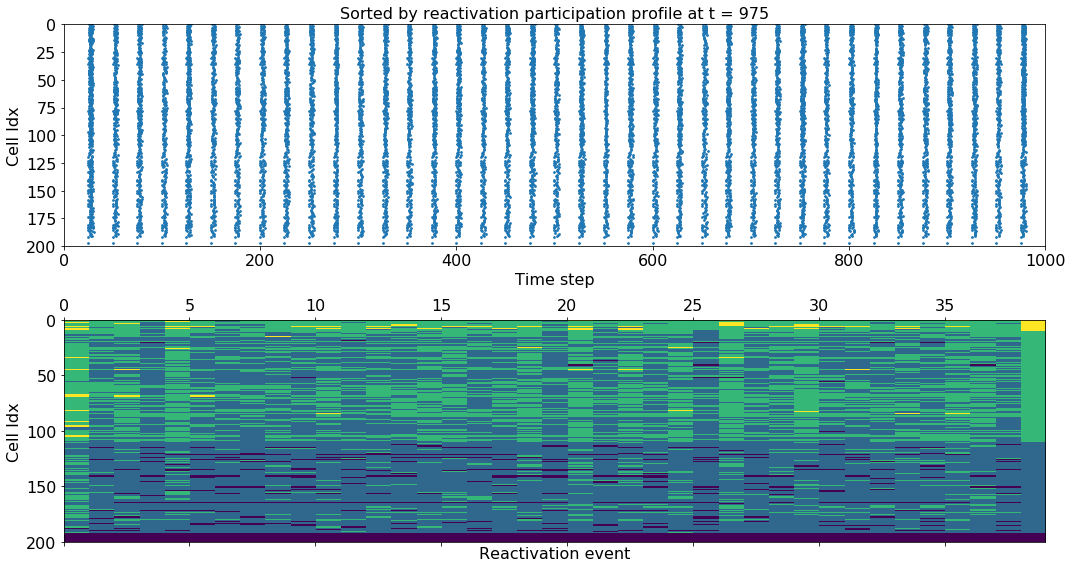

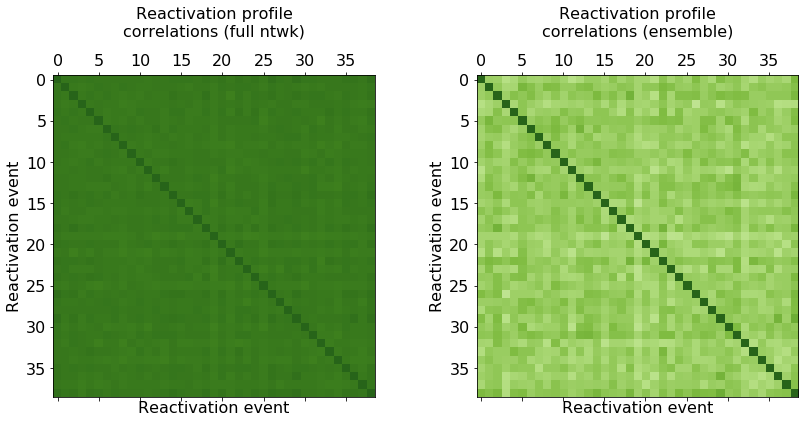

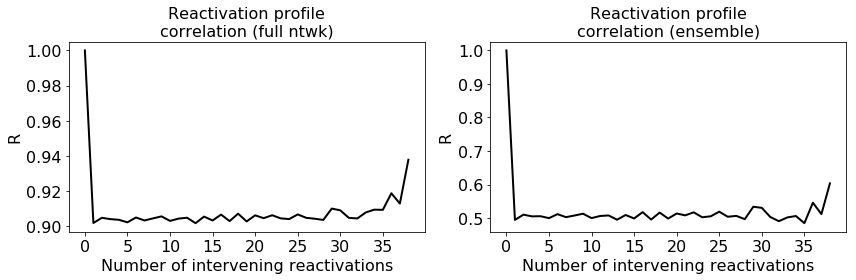

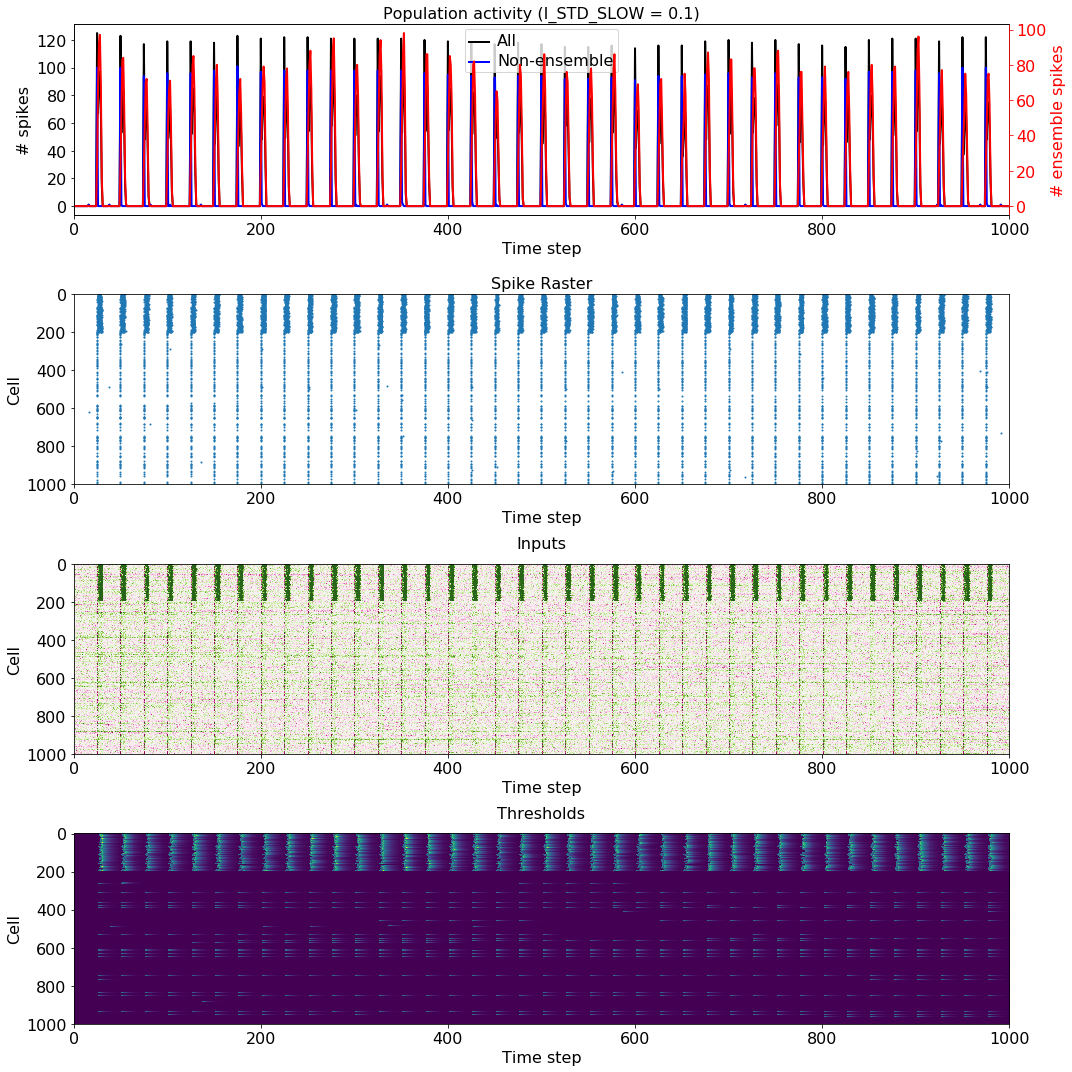

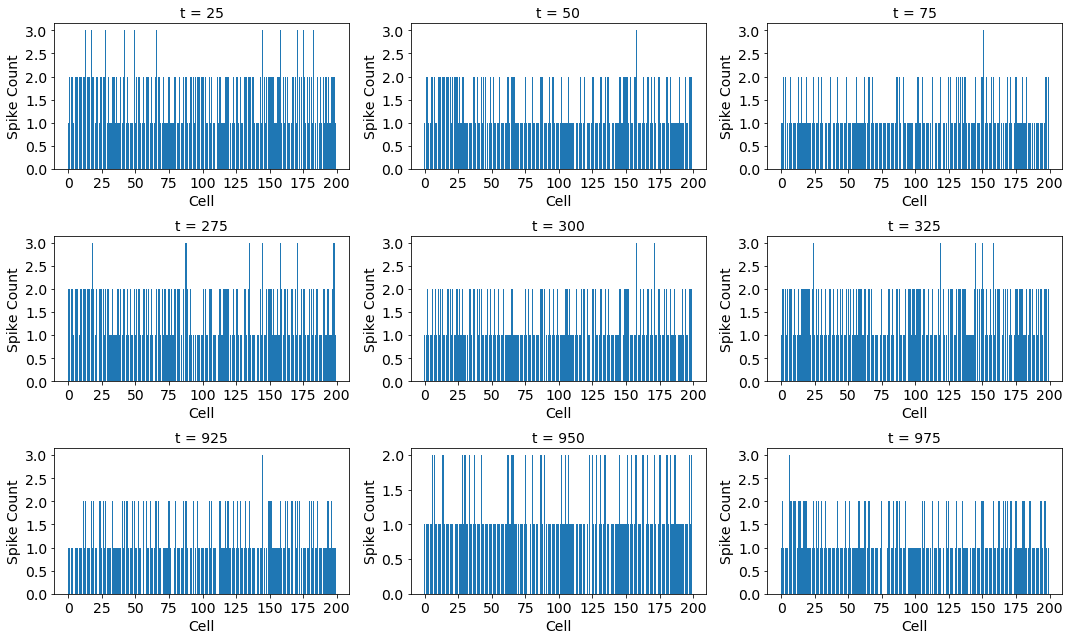

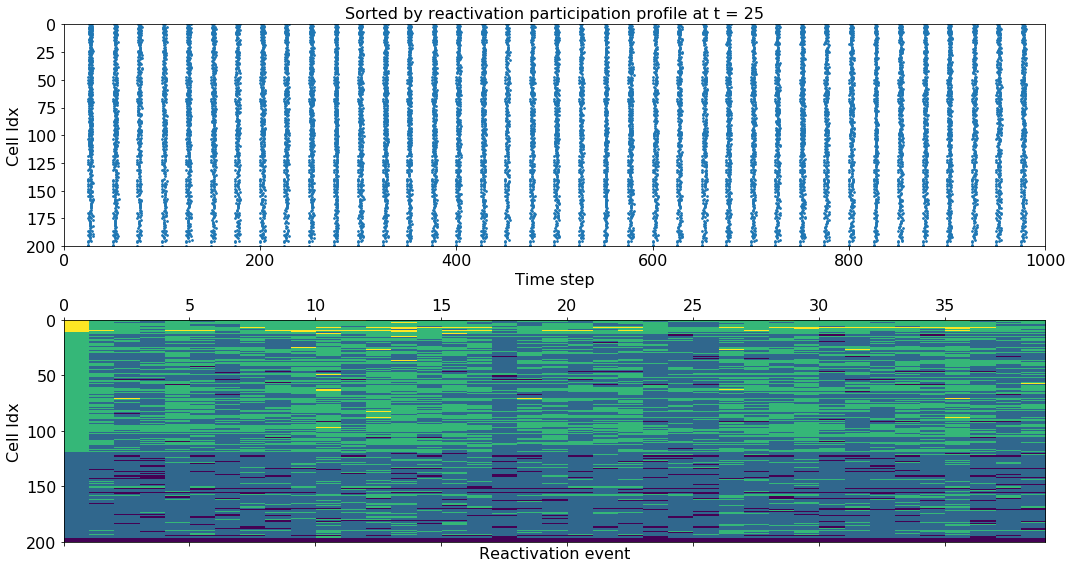

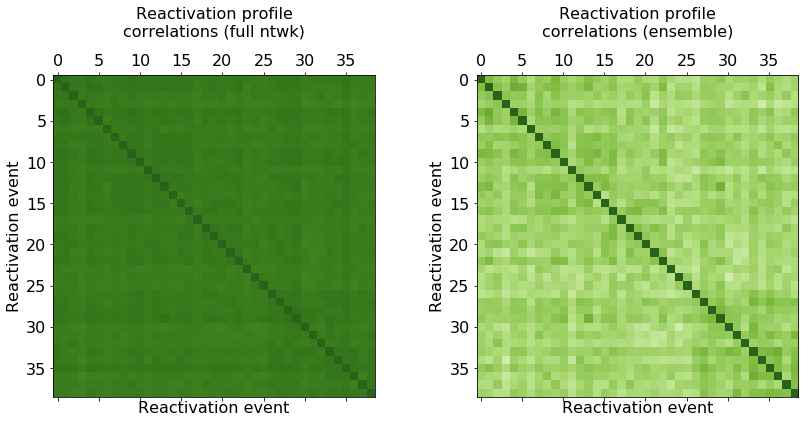

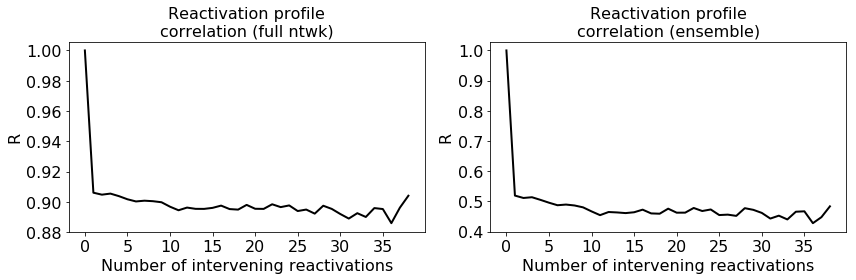

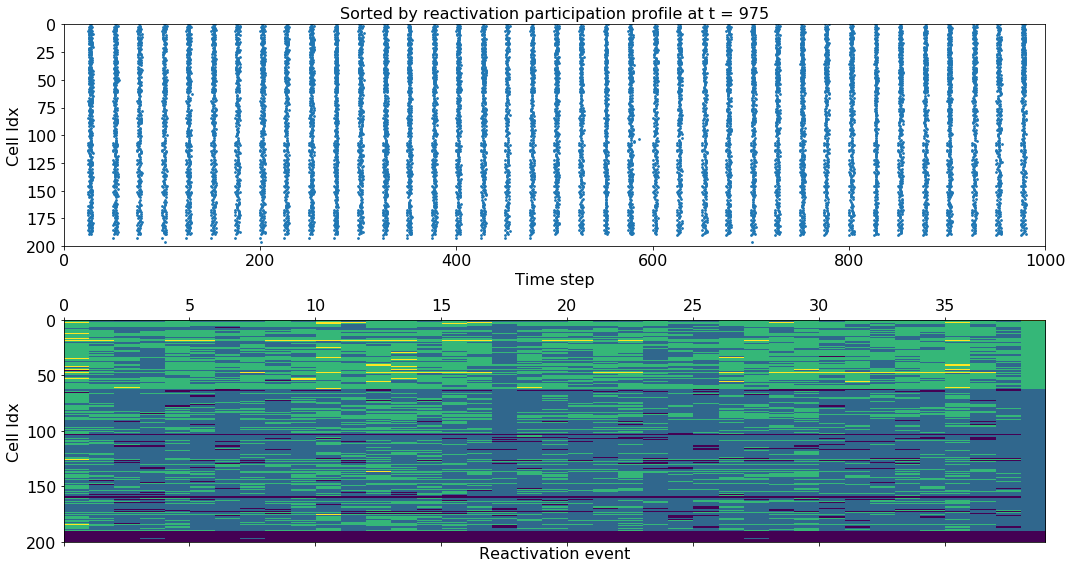

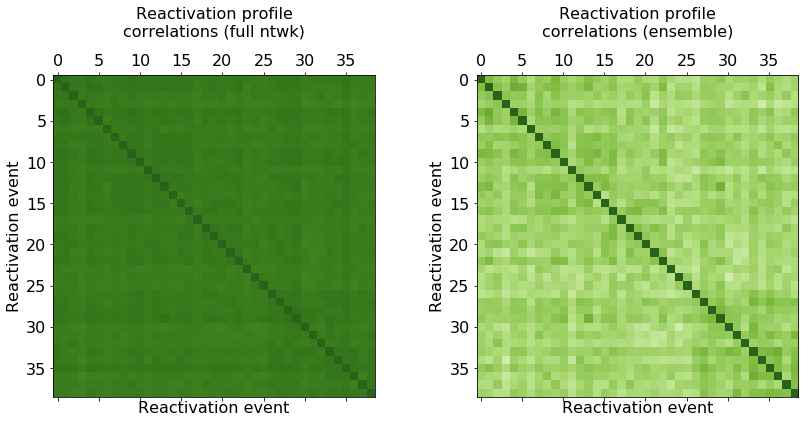

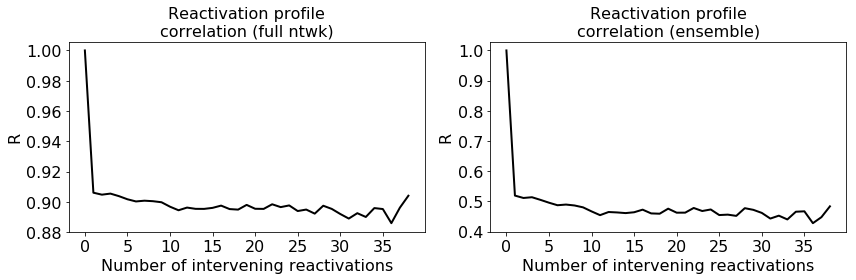

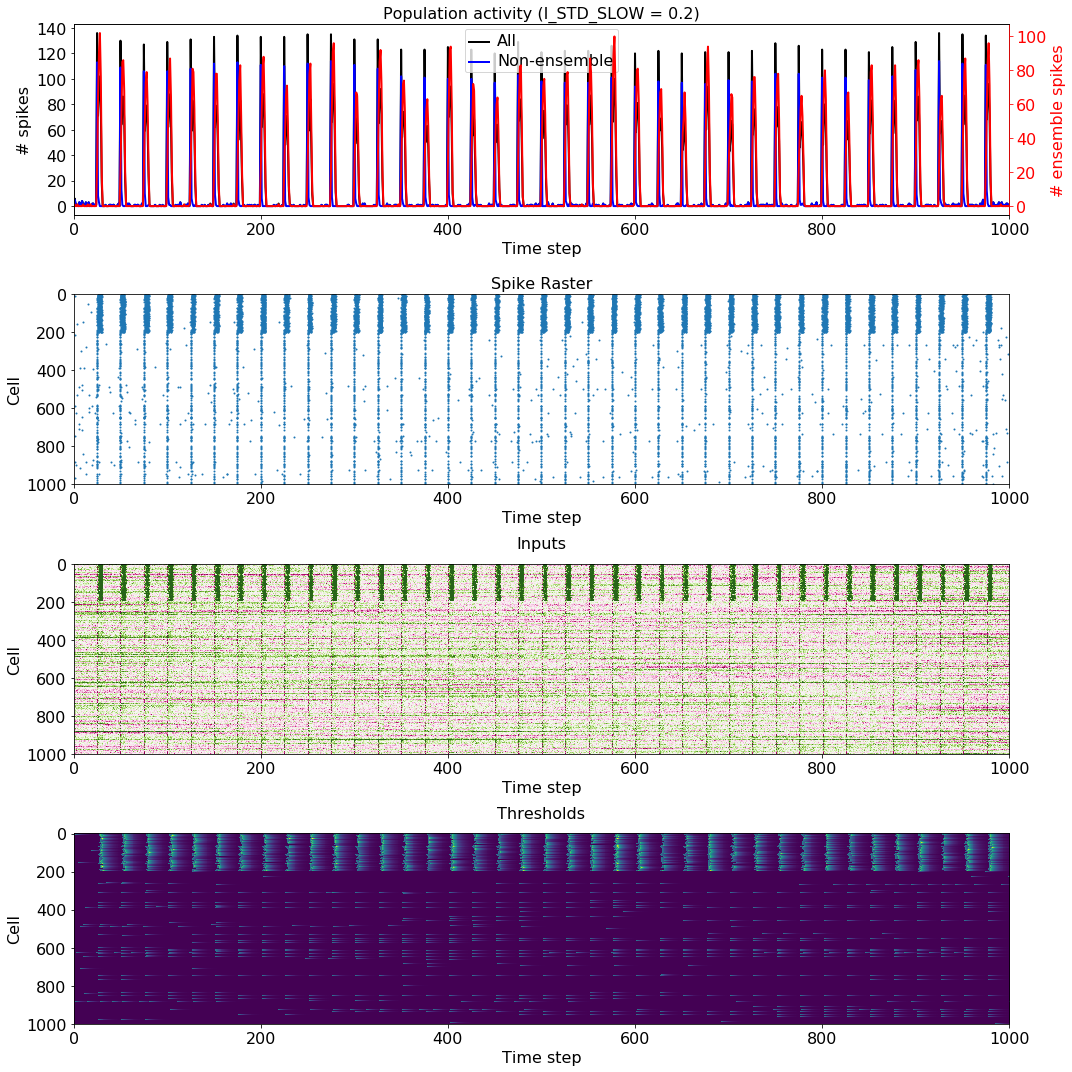

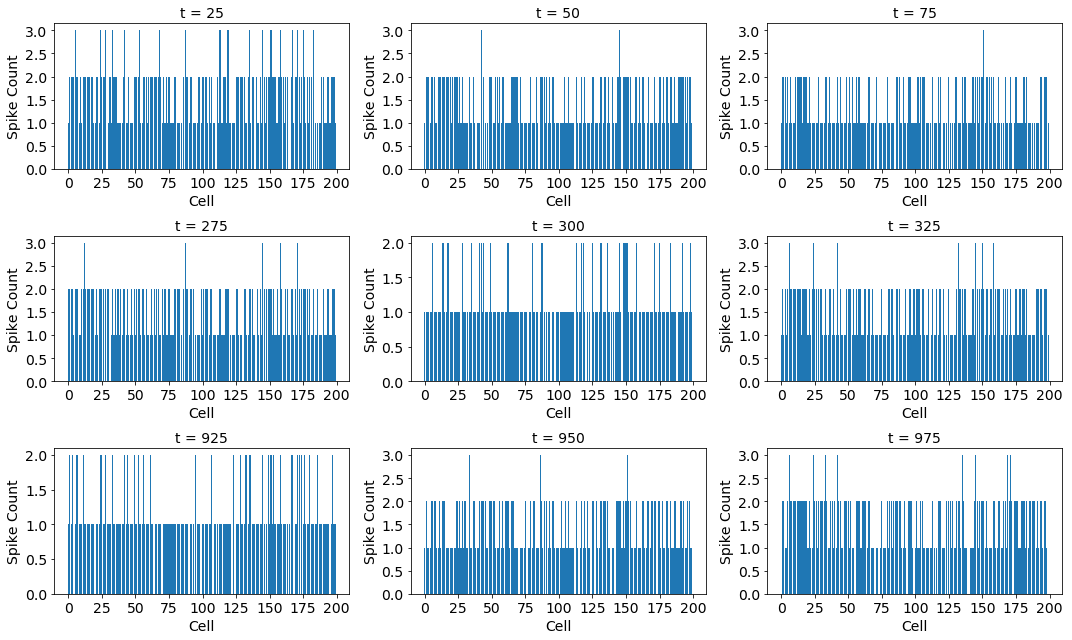

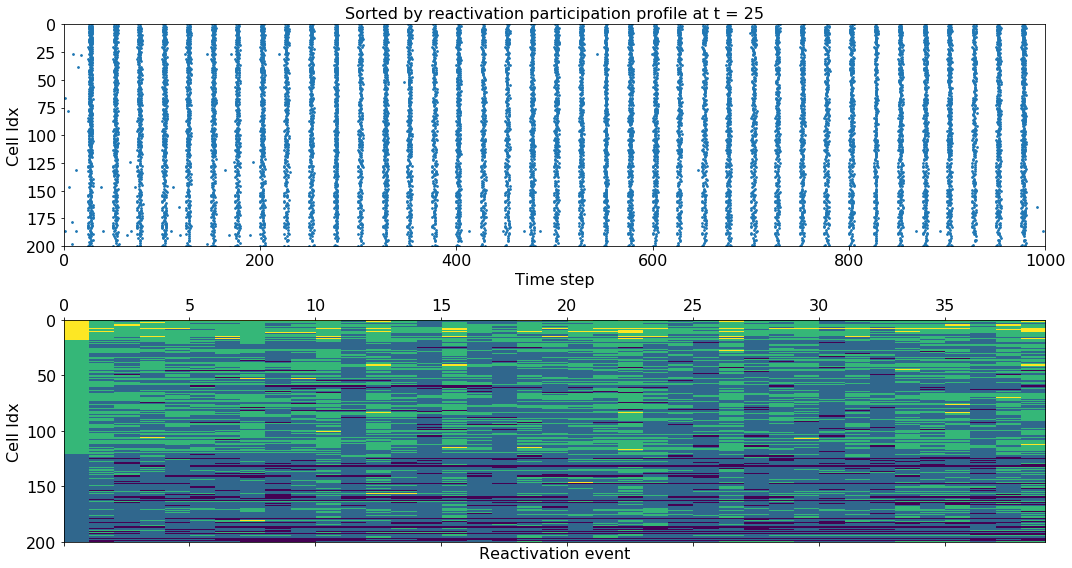

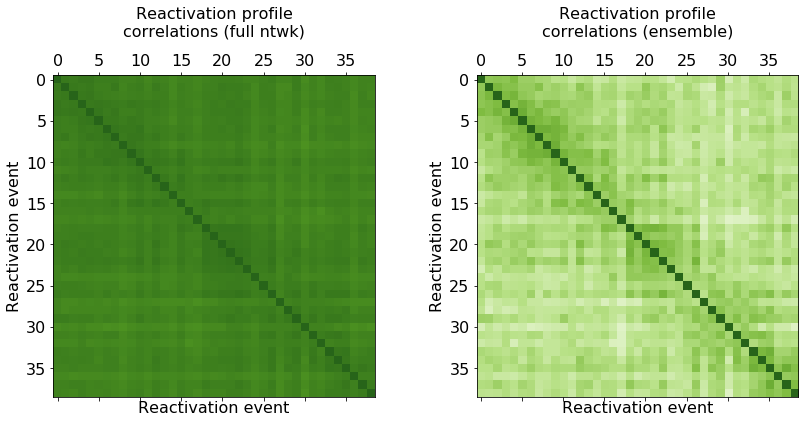

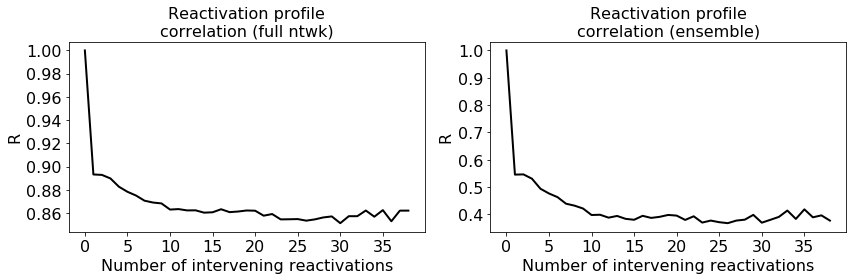

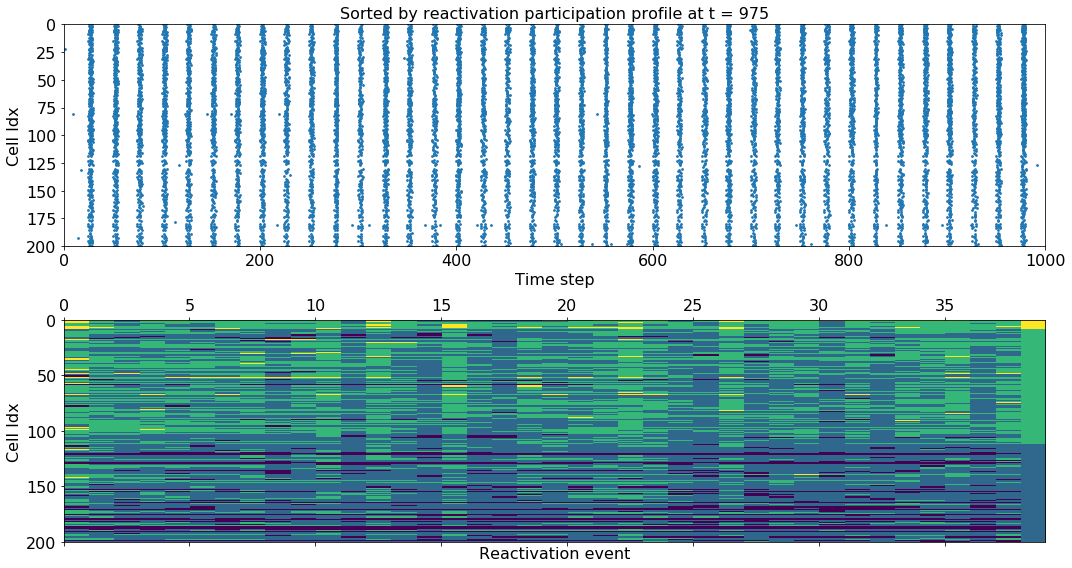

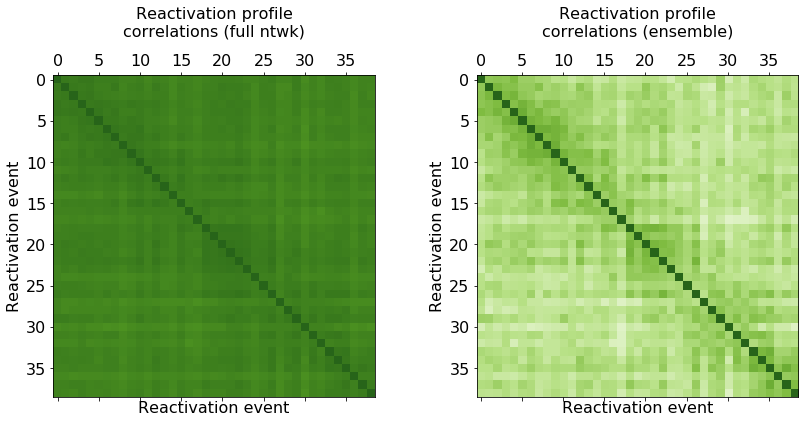

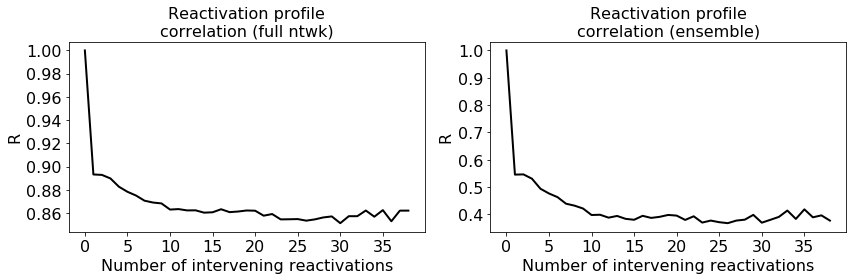

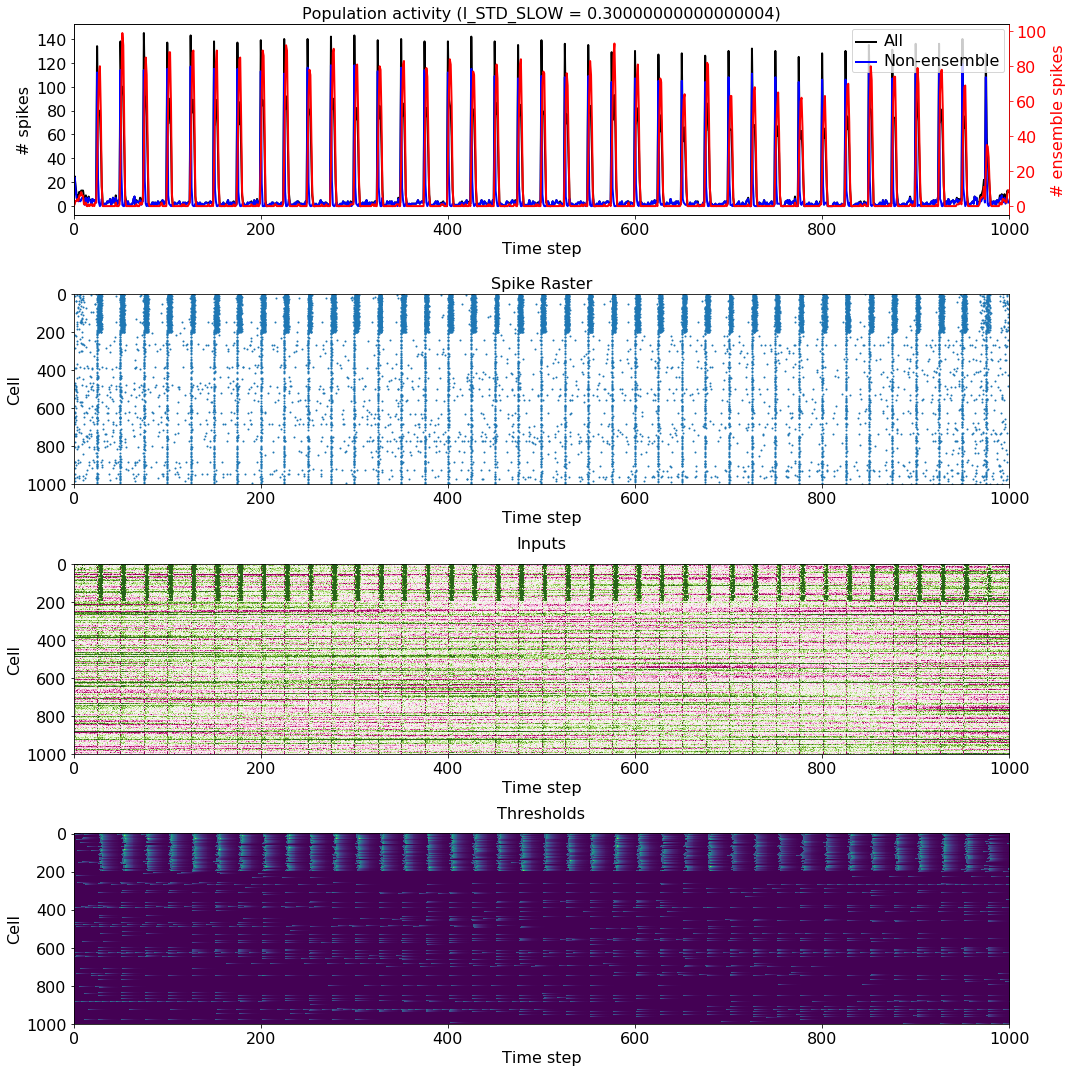

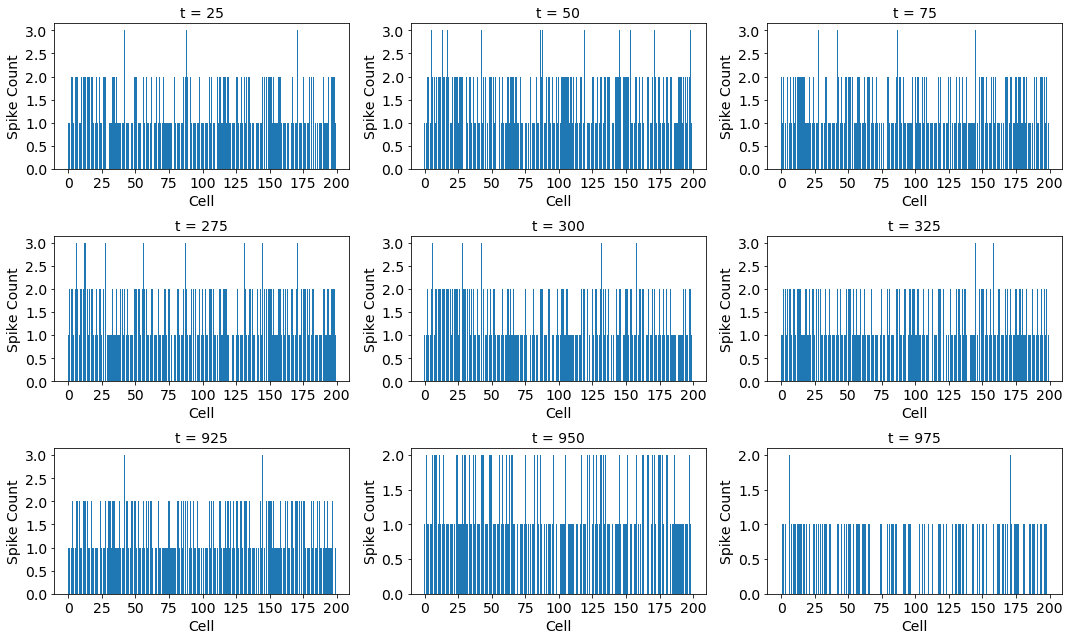

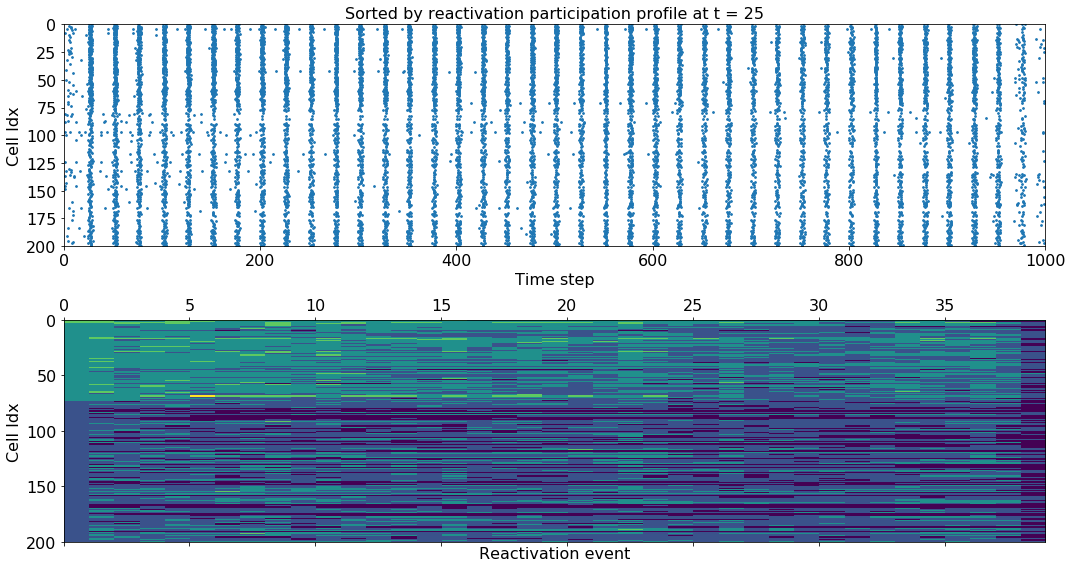

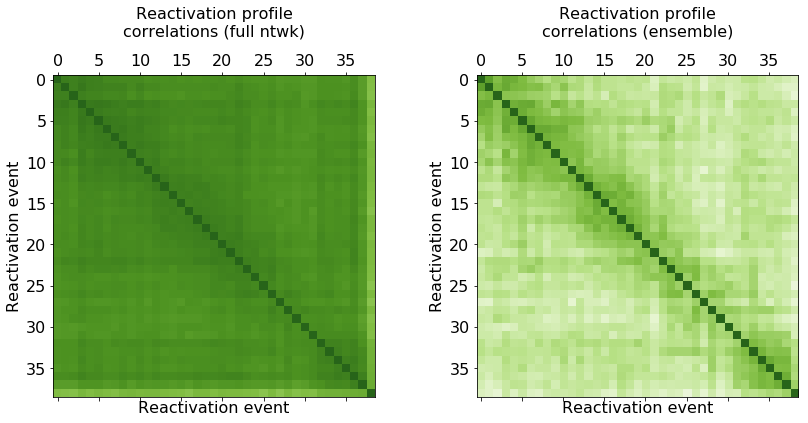

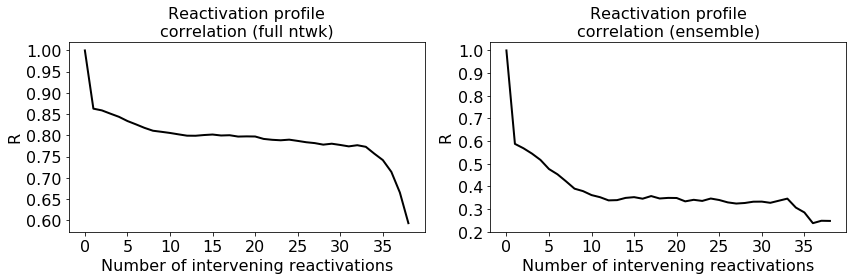

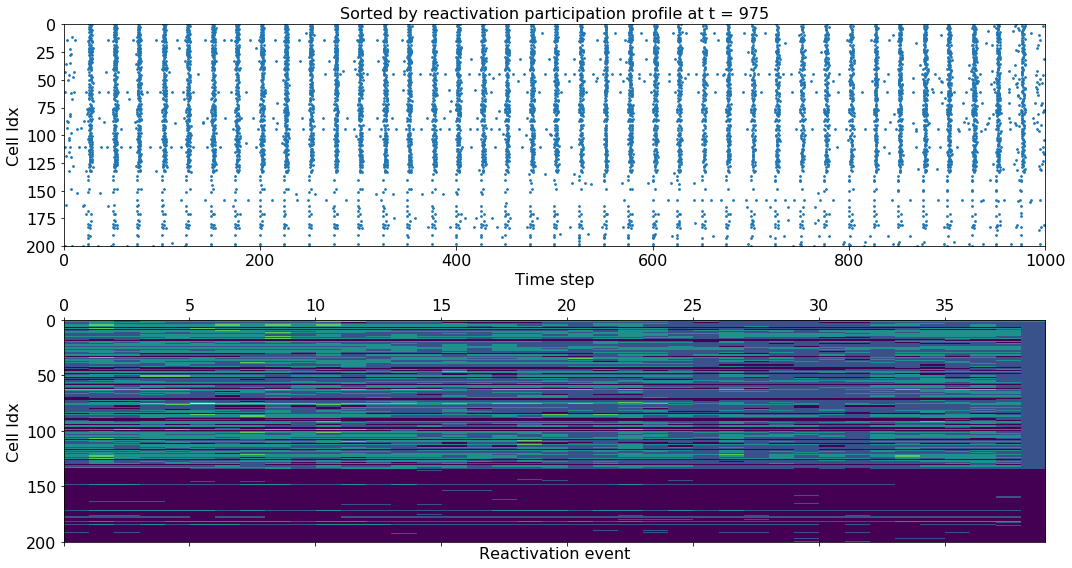

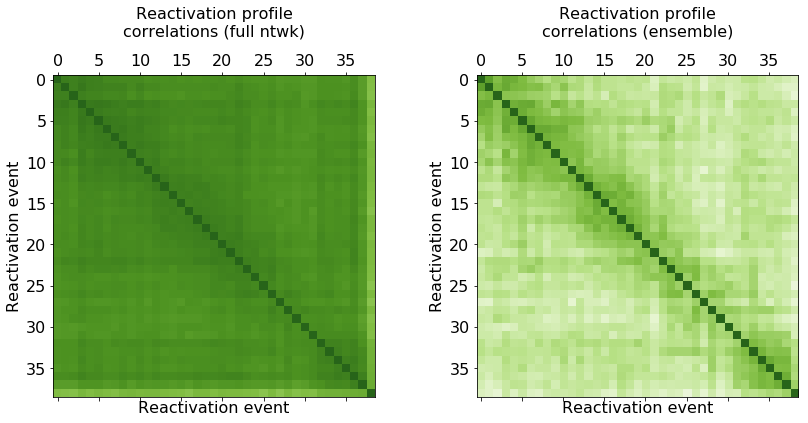

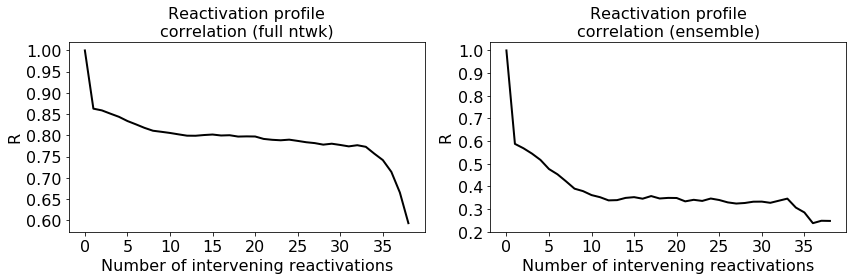

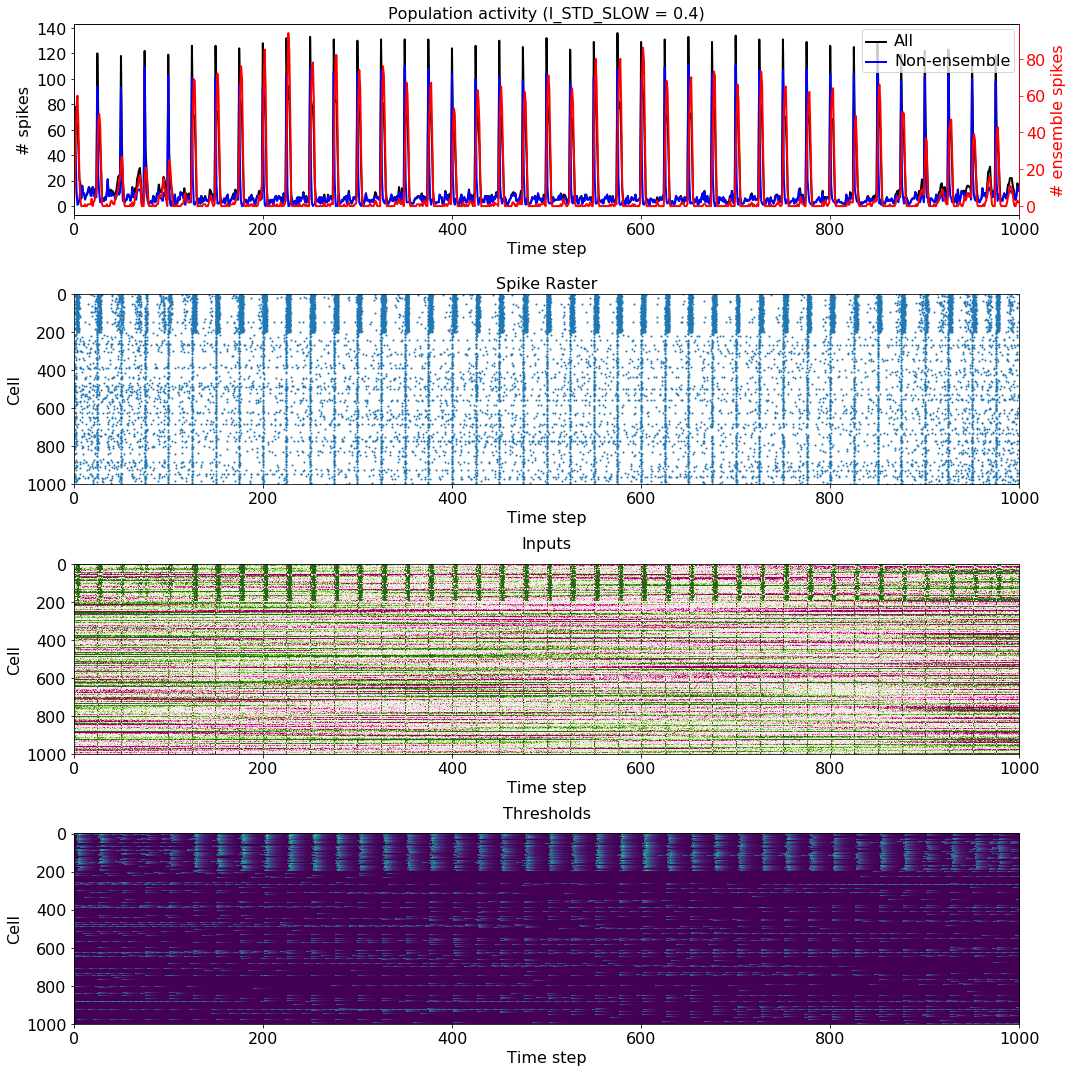

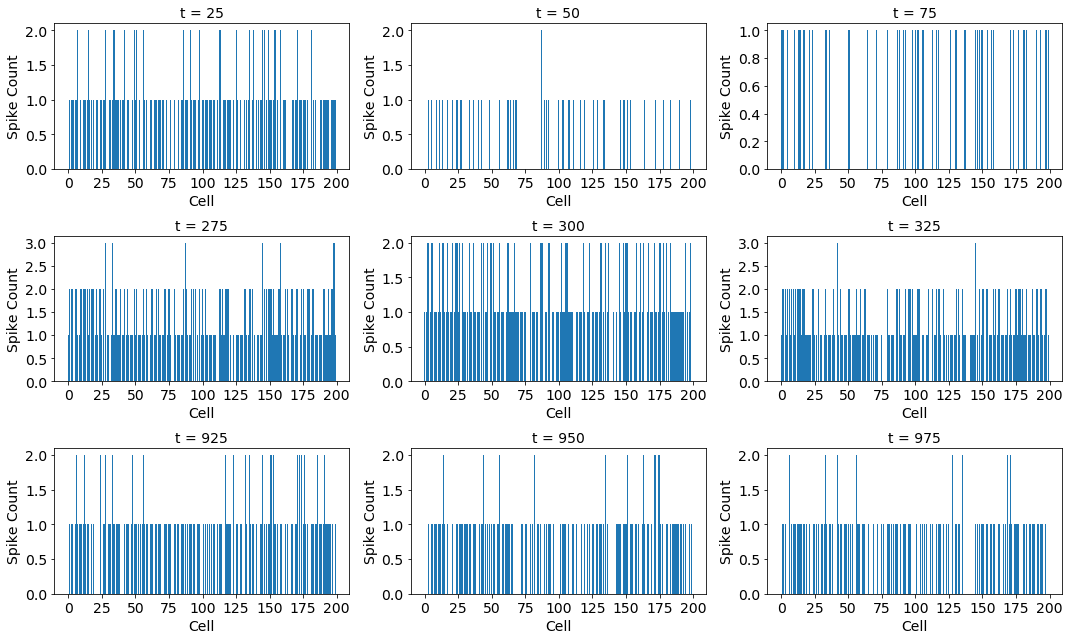

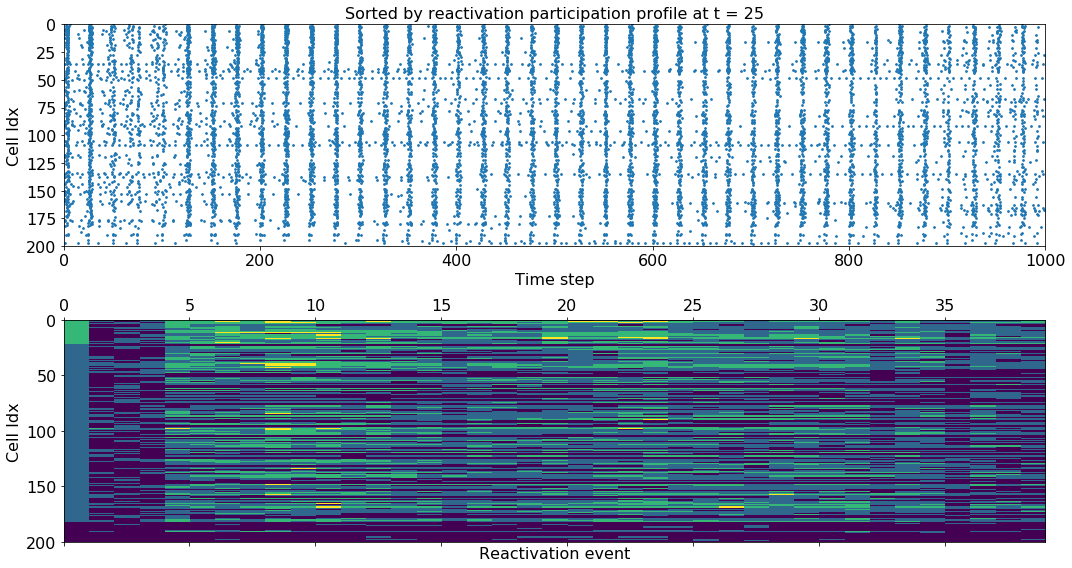

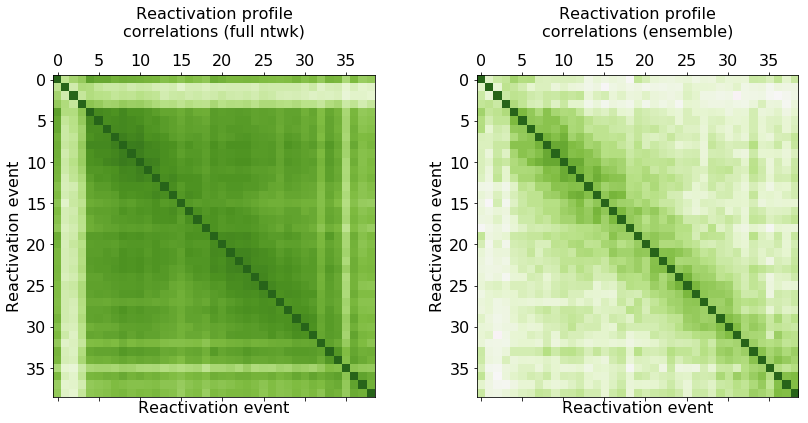

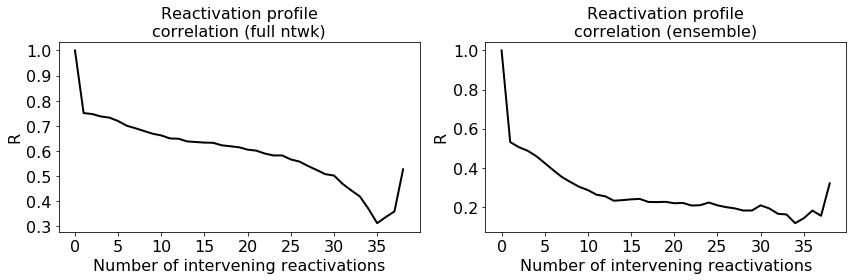

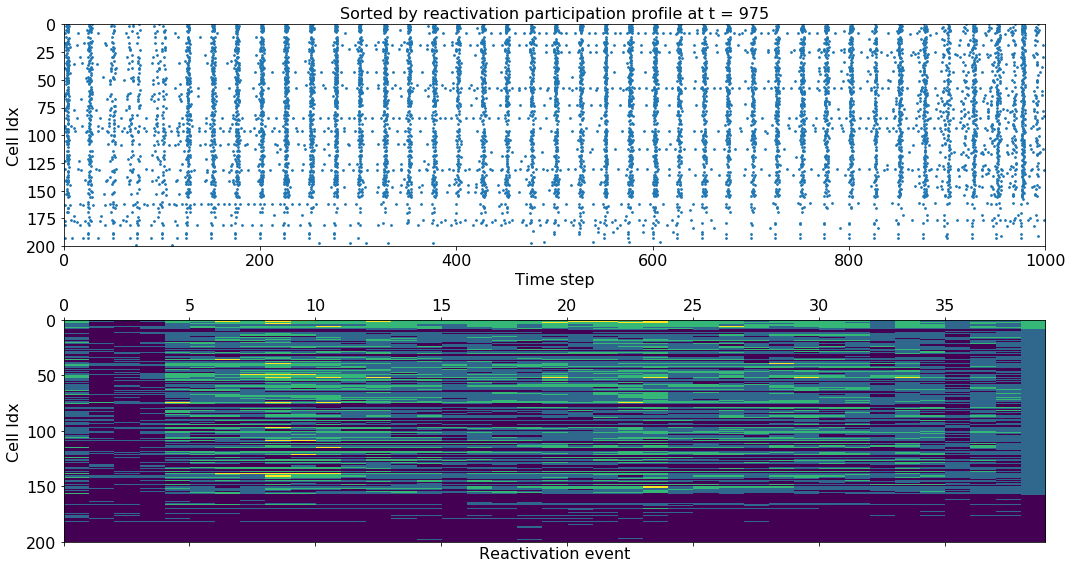

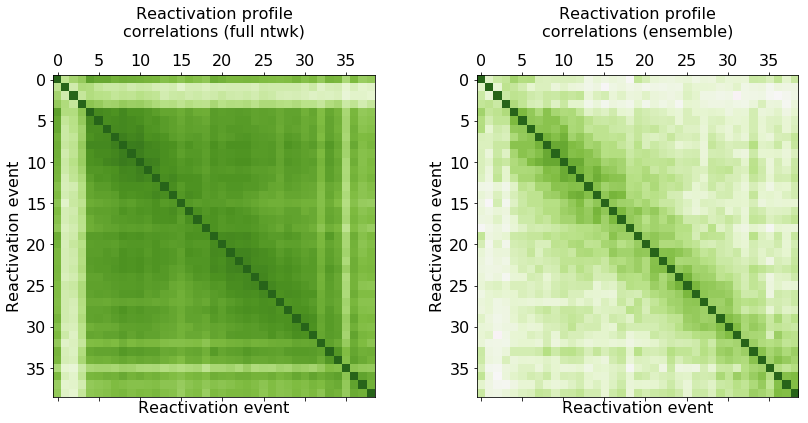

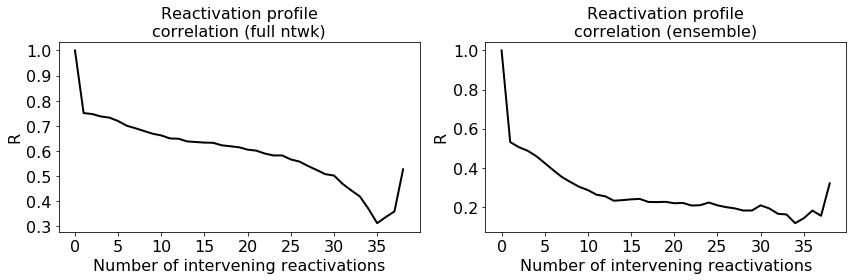

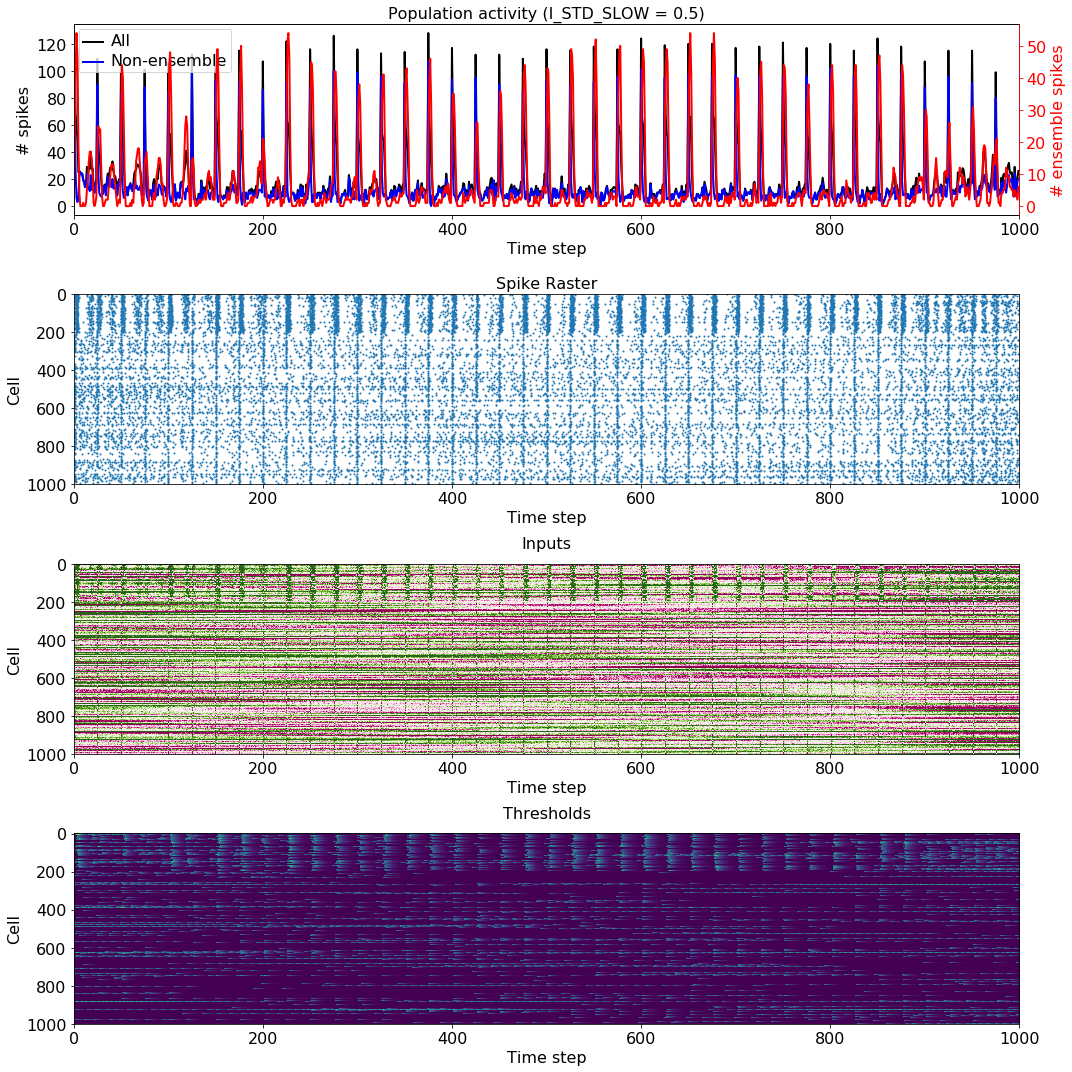

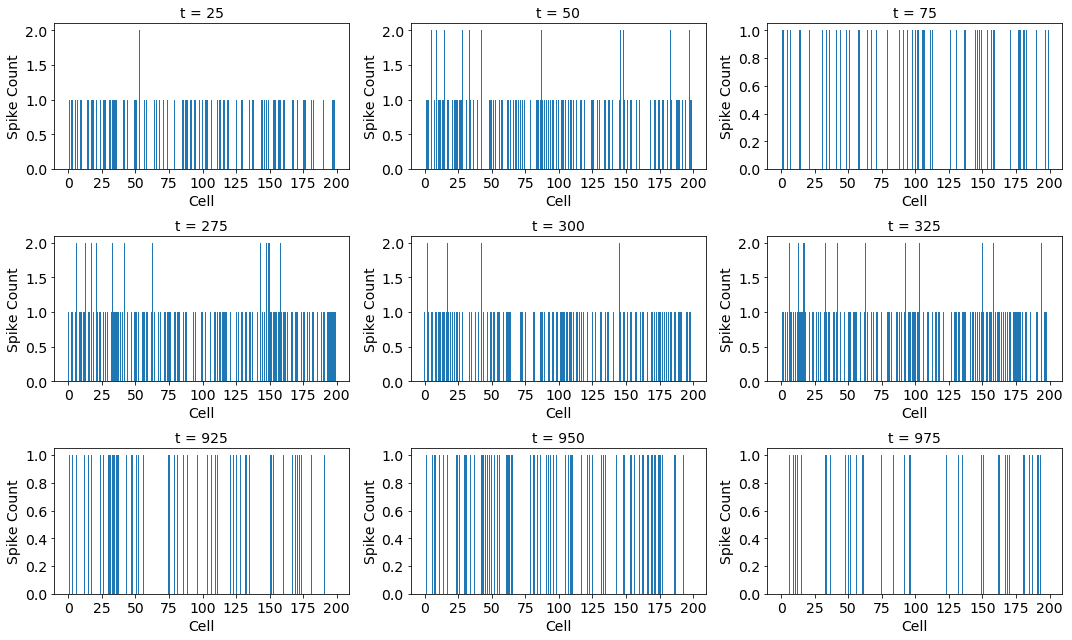

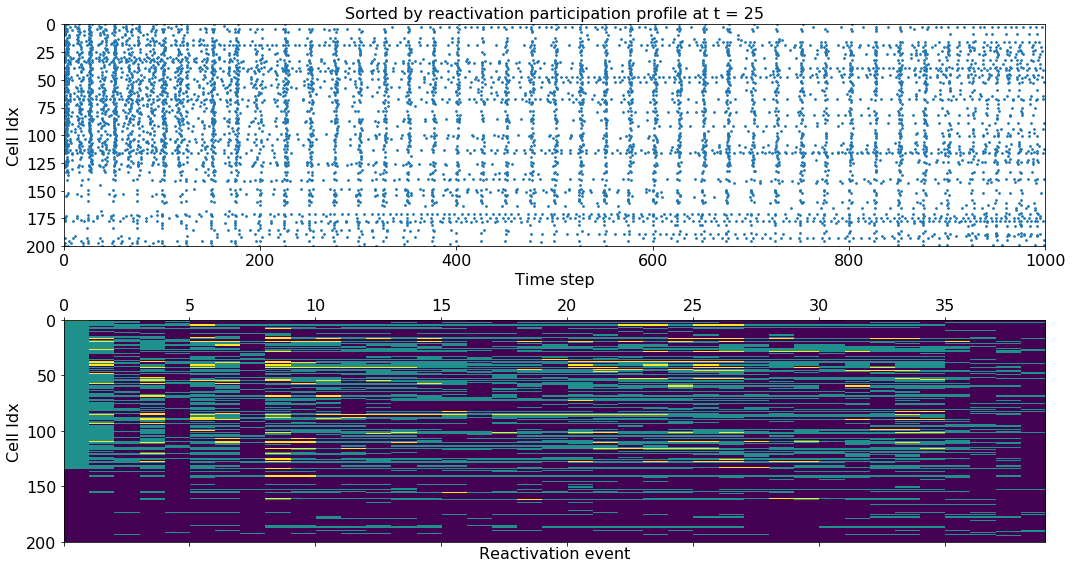

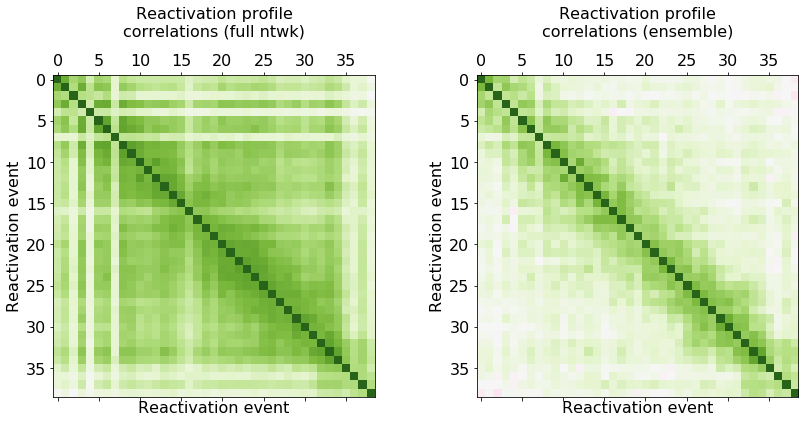

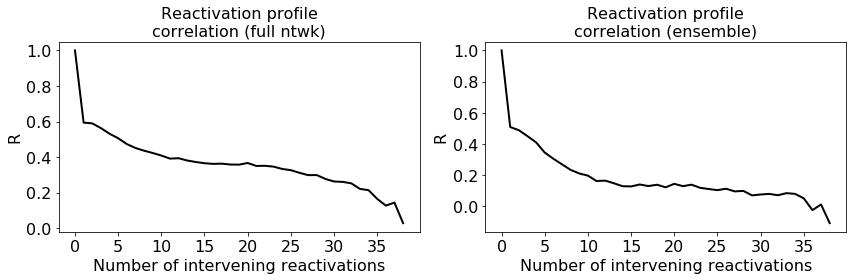

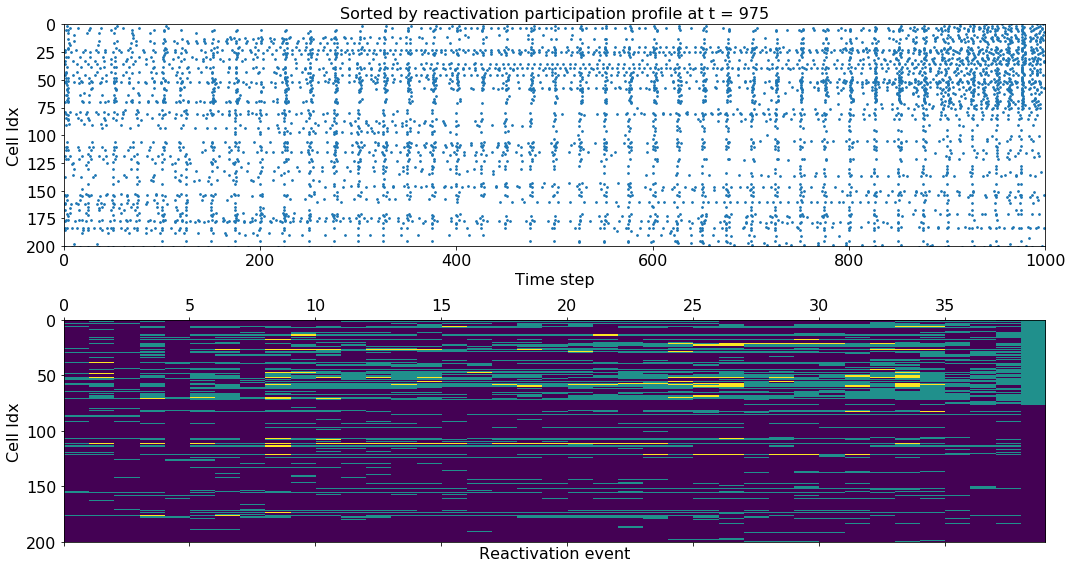

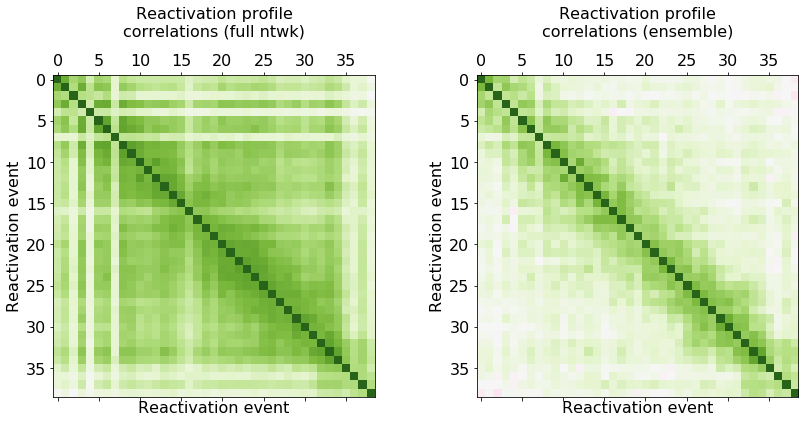

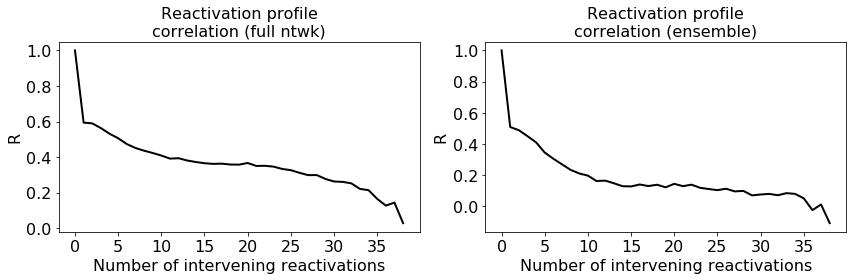

In [4]:
for rslt, i_std_slow in zip(rslt_xpl, I_STD_SLOW):
    # plot dynamics
    fig, axs = plt.subplots(4, 1, figsize=(15, 15), tight_layout=True)

    ## population activity
    axs[0].plot(rslt.t, rslt.spks.sum(1), lw=2, color='k')
    axs[0].plot(rslt.t, rslt.spks[:, ~ens_mask].sum(1), lw=2, color='b')
    axs[0].set_xlim(0, N_T)
    axs[0].set_xlabel('Time step')
    axs[0].set_ylabel('# spikes')
    axs[0].legend(['All', 'Non-ensemble'])
    axs[0].set_title('Population activity (I_STD_SLOW = {})'.format(i_std_slow))

    ax_twin = axs[0].twinx()
    ax_twin.plot(rslt.t, rslt.spks[:, ens_mask].sum(1), lw=2, color='r')
    ax_twin.set_xlim(0, N_T)
    ax_twin.set_ylabel('# ensemble spikes')

    set_color(ax_twin, 'r')

    ## raster
    axs[1].scatter(*np.nonzero(rslt.spks), s=1)
    axs[1].set_xlim(0, N_T)
    axs[1].set_ylim(N, -1)
    axs[1].set_xlabel('Time step')
    axs[1].set_ylabel('Cell')
    axs[1].set_title('Spike Raster')

    ## inputs
    axs[2].matshow(rslt.vs.T, origin='upper', aspect='auto', cmap='PiYG', vmin=-1, vmax=1)
    axs[2].xaxis.tick_bottom()
    axs[2].set_xlim(0, N_T)
    axs[2].set_xlabel('Time step')
    axs[2].set_ylabel('Cell')
    axs[2].set_title('Inputs')

    ## thresholds
    axs[3].matshow(rslt.thts.T, origin='upper', aspect='auto')
    axs[3].xaxis.tick_bottom()
    axs[3].set_xlim(0, N_T)
    axs[3].set_xlabel('Time step')
    axs[3].set_ylabel('Cell')
    axs[3].set_title('Thresholds')

    for ax in list(axs) + [ax_twin]:
        set_font_size(ax, 16)
        
    # plot reactivation profiles
    fig, axs = fast_fig(len(PRFL_CTR), ax_size=(3, 5), fig_w=15)
    for ax, ctr, prfl in zip(axs, PRFL_CTR, rslt.prfls):
        ax.bar(np.arange(M), prfl[:M], align='center')
        ax.set_xlabel('Cell')
        ax.set_ylabel('Spike Count')
        ax.set_title('t = {}'.format(T_REAC[ctr]))
        set_font_size(ax, 14)

    # plot rasters sorted by initial and final participations
    for ctr in [0, -1]:

        fig, axs = plt.subplots(2, 1, figsize=(15, 8), tight_layout=True)
        spk_t, spk_idx_ = np.nonzero(rslt.spks)
        # reindex spikes to be sorted by participation in reactivation profile
        spk_idx = np.argsort(rslt.orders[ctr])[spk_idx_]

        # plot raster
        axs[0].scatter(spk_t, spk_idx, s=3)
        axs[0].set_xlim(0, N_T)
        axs[0].set_ylim(M, 0)
        axs[0].set_xlabel('Time step')
        axs[0].set_ylabel('Cell Idx')
        axs[0].set_title('Sorted by reactivation participation profile at t = {}'.format(T_REAC[PRFL_CTR[ctr]]))

        # plot reactivation profile evolution
        axs[1].matshow(rslt.prfls_full[:, rslt.orders[ctr]].T, extent=[0, len(T_REAC), N, 0])
        axs[1].set_aspect('auto')
        axs[1].set_ylim(M, 0)
        axs[1].set_xlabel('Reactivation event')
        axs[1].set_ylabel('Cell Idx')

        for ax in axs:
            set_font_size(ax, 16)

        # plot reactivation profile correlation across reactivation events
        fig, axs = plt.subplots(1, 2, figsize=(12, 6), tight_layout=True)
        axs[0].matshow(rslt.r_prfls_full, interpolation='nearest', cmap='PiYG', vmin=-1, vmax=1)
        axs[0].set_title('Reactivation profile\ncorrelations (full ntwk)\n')

        axs[1].matshow(rslt.r_prfls_ens, interpolation='nearest', cmap='PiYG', vmin=-1, vmax=1)
        axs[1].set_title('Reactivation profile\ncorrelations (ensemble)\n')

        for ax in axs:
            ax.set_xlabel('Reactivation event')
            ax.set_ylabel('Reactivation event')
            set_font_size(ax, 16)

        # plot reactivation profile correlation vs time diff btwn events
        fig, axs = plt.subplots(1, 2, figsize=(12, 4), tight_layout=True)

        axs[0].plot(np.arange(len(T_REAC)), rslt.r_v_dt_full, c='k', lw=2)
        axs[0].set_title('Reactivation profile\ncorrelation (full ntwk)')

        axs[1].plot(np.arange(len(T_REAC)), rslt.r_v_dt_ens, c='k', lw=2)
        axs[1].set_title('Reactivation profile\ncorrelation (ensemble)')

        for ax in axs:
            ax.set_xlabel('Number of intervening reactivations')
            ax.set_ylabel('R')

            set_font_size(ax, 16)